In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Class to print string in bold
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
# functions to show an image

def imshow(img, title = False):

    plt.imshow(np.transpose(img, (1, 2, 0)))
    if(title):
        plt.title("{}".format(title))
    plt.show()


# MNIST dataset

In [ ]:
TrainData = datasets.MNIST('../data/', download=True, transform=transforms.ToTensor(), train=True)
train_loader = torch.utils.data.DataLoader(TrainData,batch_size=34)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:03<00:00, 3214749.66it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 160458.02it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1299376.06it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3498077.26it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self,  image_size = 28, channel_num = 1, kernel_num = 128, z_size = 8):
        # configurations
        super().__init__()
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        self.num_encoder_layers = 2

        # encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 2),

            self._conv(kernel_num // 2, kernel_num)
        )

        # encoded feature's size and volume
        self.feature_size = image_size // (2**self.num_encoder_layers)
        self.feature_volume = kernel_num * (self.feature_size ** 2)

        self.q_mean = self._linear(self.feature_volume, z_size, relu=False)
        self.q_logvar = self._linear(self.feature_volume, z_size, relu=False)

        # projection
        self.project = self._linear(z_size, self.feature_volume, relu=False)


        # decoder
        self.decoder = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),

            self._deconv(kernel_num // 2, channel_num),


            nn.ReLU()
        )


    def forward(self, x):
        # encode x
        encoded = self.encoder(x)

        mean, logvar = self.q(encoded)
        z = self.z(mean, logvar)
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)
        return (mean, logvar, x_reconstructed)

    # ==============
    # VAE components
    # ==============

    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).to(device)
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.MSELoss(size_average=False)(x_reconstructed, x)/ x.size(0)
    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()


    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num):
        return nn.Sequential(
            nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num):
        return nn.Sequential(
            nn.ConvTranspose2d(
                channel_num, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)

In [ ]:
model = VAE().to(device)
optimizer_vae = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Train Function

In [ ]:
def train(epoch):
    train_loss = 0
    recon_loss = 0
    kl_loss = 0
    recon_batch = None
    for batch_idx, (data, classes) in enumerate(train_loader):
            data, classes = data.to(device), classes.to(device)
            optimizer_vae.zero_grad()
            mu, logvar, recon_batch = model(data)


            reconstruction_loss = model.reconstruction_loss(recon_batch, data)
            kl_divergence_loss = model.kl_divergence_loss(mu, logvar)
            recon_loss += reconstruction_loss.item()
            loss = reconstruction_loss + kl_divergence_loss #+ 100*quantile_loss
            kl_loss += kl_divergence_loss.item()
            loss.backward()
            train_loss += loss.item()
            optimizer_vae.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / (len(train_loader)*20)))
    print('====> Epoch: {} Average Reconstruction loss: {:.4f}'.format(
        epoch, recon_loss / (len(train_loader)*20)))
    print('====> Epoch: {} Average KL loss: {:.4f}'.format(
        epoch, kl_loss / (len(train_loader)*20)))

    if (True):#(epoch % 10 == 0):
        print(color.BOLD + 'Original Samples:' + color.END)
        imshow(torchvision.utils.make_grid(data.cpu()))
        print(color.BOLD + 'Generated Generated:' + color.END)
        imshow(torchvision.utils.make_grid(recon_batch.view(-1,1,28,28).detach().cpu()))


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch: 1 Average loss: 1.5576
====> Epoch: 1 Average Reconstruction loss: 1.4433
====> Epoch: 1 Average KL loss: 0.1143
Original Samples:


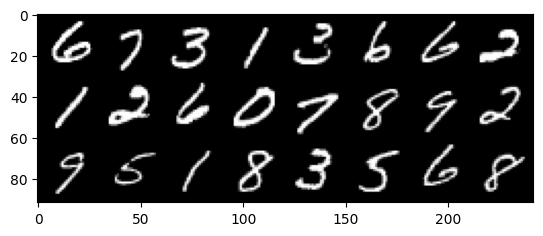

Generated Generated:


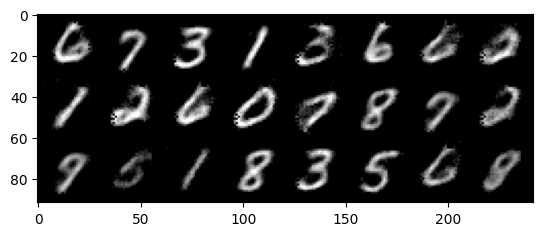

====> Epoch: 2 Average loss: 1.1252
====> Epoch: 2 Average Reconstruction loss: 1.0003
====> Epoch: 2 Average KL loss: 0.1248
Original Samples:


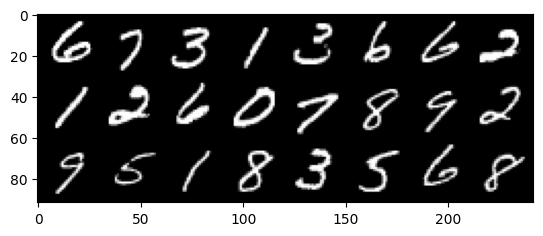

Generated Generated:


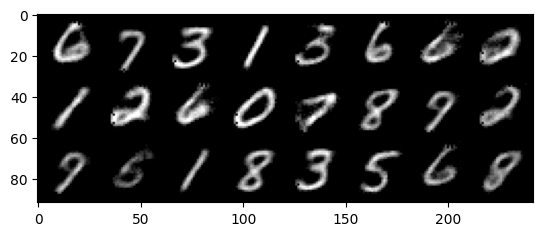

====> Epoch: 3 Average loss: 1.0391
====> Epoch: 3 Average Reconstruction loss: 0.9118
====> Epoch: 3 Average KL loss: 0.1273
Original Samples:


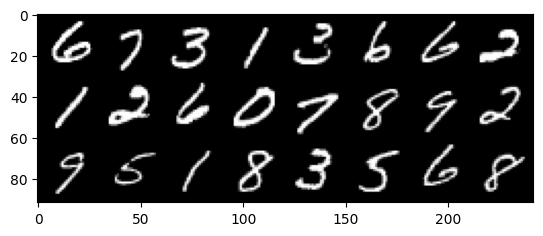

Generated Generated:


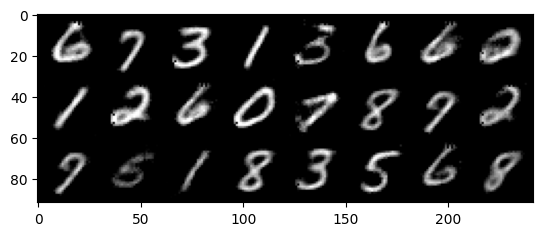

====> Epoch: 4 Average loss: 0.9911
====> Epoch: 4 Average Reconstruction loss: 0.8625
====> Epoch: 4 Average KL loss: 0.1286
Original Samples:


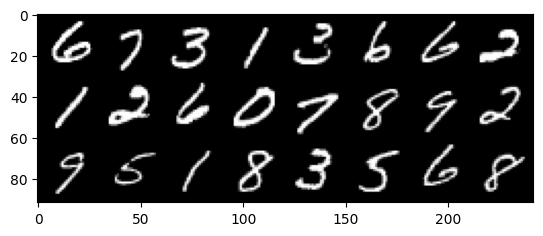

Generated Generated:


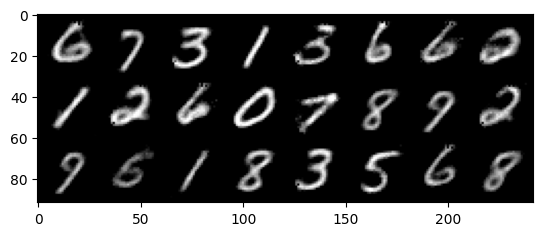

====> Epoch: 5 Average loss: 0.9568
====> Epoch: 5 Average Reconstruction loss: 0.8270
====> Epoch: 5 Average KL loss: 0.1298
Original Samples:


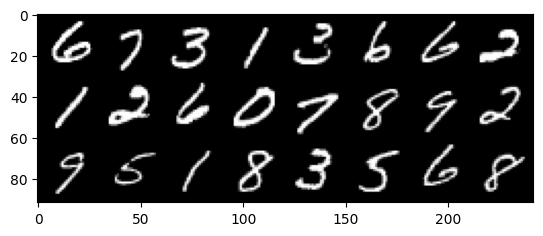

Generated Generated:


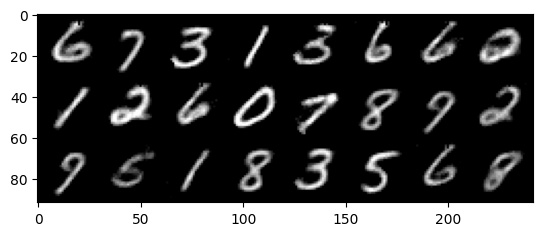

====> Epoch: 6 Average loss: 0.9319
====> Epoch: 6 Average Reconstruction loss: 0.8014
====> Epoch: 6 Average KL loss: 0.1305
Original Samples:


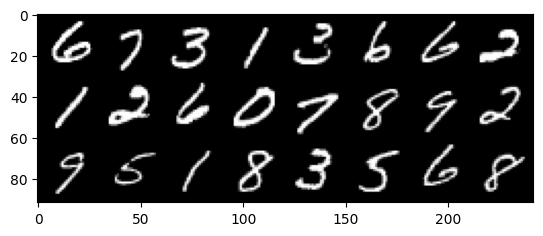

Generated Generated:


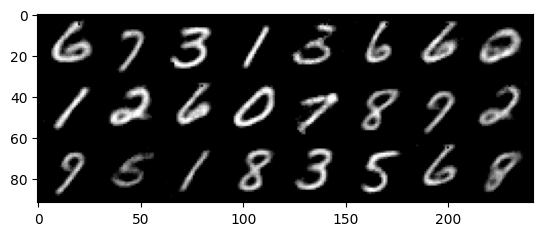

====> Epoch: 7 Average loss: 0.9124
====> Epoch: 7 Average Reconstruction loss: 0.7814
====> Epoch: 7 Average KL loss: 0.1310
Original Samples:


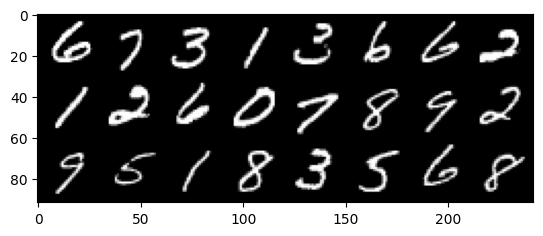

Generated Generated:


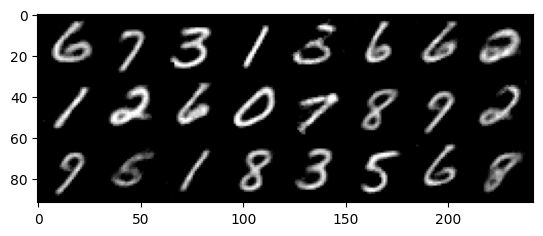

====> Epoch: 8 Average loss: 0.8967
====> Epoch: 8 Average Reconstruction loss: 0.7652
====> Epoch: 8 Average KL loss: 0.1315
Original Samples:


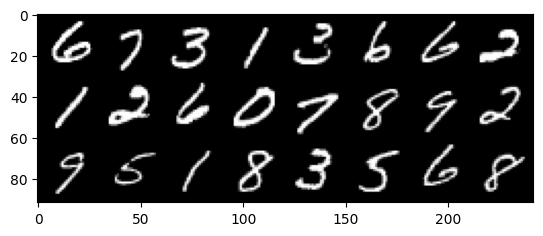

Generated Generated:


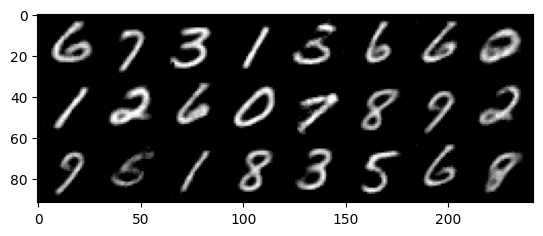

====> Epoch: 9 Average loss: 0.8838
====> Epoch: 9 Average Reconstruction loss: 0.7518
====> Epoch: 9 Average KL loss: 0.1319
Original Samples:


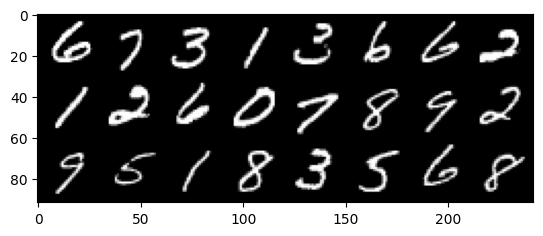

Generated Generated:


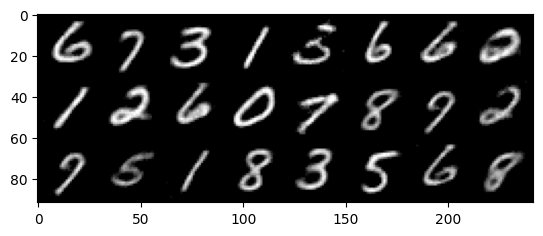

====> Epoch: 10 Average loss: 0.8725
====> Epoch: 10 Average Reconstruction loss: 0.7402
====> Epoch: 10 Average KL loss: 0.1322
Original Samples:


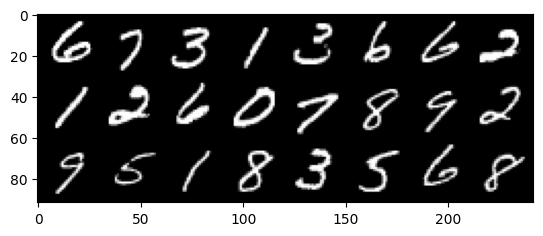

Generated Generated:


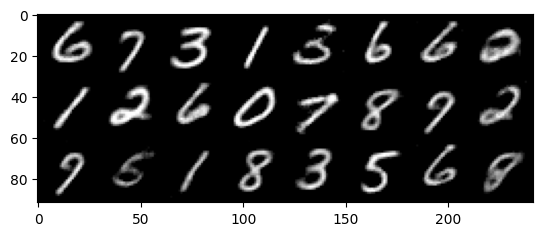

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(epoch)

#Evaluating decoder on a random input

tensor([ 0.1287, -1.2129, -0.6034,  0.2663, -0.1218, -0.0486,  0.9144,  0.2247])
torch.Size([1, 128, 7, 7])
Generated :


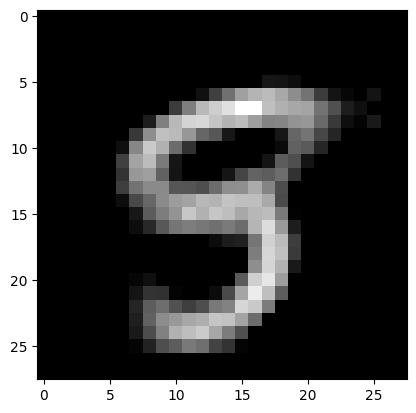

In [ ]:
z_size = 8 #torch.Size([5,8])
image_size = 28
num_encoder_layers = 2
feature_size = image_size // (2**num_encoder_layers)
kernel_num = 128

rand_sample = torch.randn(z_size)
print(rand_sample)

z_projected = model.project(rand_sample).view(
            -1, kernel_num,
            feature_size,
            feature_size,
        )
print(z_projected.shape)
# reconstruct x from z
x_generated = model.decoder(z_projected)

print(color.BOLD + 'Generated :' + color.END)
imshow(torchvision.utils.make_grid(x_generated.view(-1,1,28,28).detach().cpu()))

# Source: https://github.com/SashaMalysheva/Pytorch-VAE